In [1]:
import numpy as np
import datetime
import matplotlib.pylab as plt
from dataloader import DataLoader
import tensorflow as tf
from tensorflow.contrib.learn.python.learn.datasets import base
from tensorflow.python.framework import dtypes

## 数据预处理

#### 进行数据预处理，根据输入DataLoader已经下载并处理好的数据image，labels，生成Datasets

In [2]:
class DataSet(object):
    def __init__(self, images, labels, dtype= dtypes.float32):

        if dtype not in (dtypes.uint8, dtypes.float32):
            raise TypeError('Invalid images dtype %r, expected uint8 or float32' %dtype)
        else:
            assert images.shape[0] == labels.shape[0],('images.shape: %s labels.shape: %s'%(images.shape, labels.shape))
            self._num_examples = images.shape[0]

            if dtype == dtypes.float32:
                #Convert from [0, 255] -> [0.0, 1.0]
                images = images.astype(np.float32)
                images = np.multiply(images, 1.0/255.0)
        self._images = images
        self._labels = labels
        self._epochs_completed = 0
        self._index_in_epoch = 0
    @property
    def images(self):
        return self._images

    @property
    def labels(self):
        return self._labels

    @property
    def num_examples(self):
        return self._num_examples

    @property
    def epochs_completed(self):
        return self._epochs_completed
    
    def next_batch(self, batch_size, shuffle=True):
        start = self._index_in_epoch
        # Shuffle for the first epoch
        if self._epochs_completed == 0 and start == 0 and shuffle:
            perm0 = np.arange(self._num_examples)
            np.random.shuffle(perm0)
            self._images = self.images[perm0]
            self._labels = self.labels[perm0]
        # Go to the next epoch
        if start + batch_size > self._num_examples:
          # Finished epoch
            self._epochs_completed += 1
          # Get the rest examples in this epoch
            rest_num_examples = self._num_examples - start
            images_rest_part = self._images[start:self._num_examples]
            labels_rest_part = self._labels[start:self._num_examples]
            # Shuffle the data
            if shuffle:
                perm = np.arange(self._num_examples)
                np.random.shuffle(perm)
                self._images = self.images[perm]
                self._labels = self.labels[perm]
          # Start next epoch
            start = 0
            self._index_in_epoch = batch_size - rest_num_examples
            end = self._index_in_epoch
            
            images_new_part = self._images[start:end]
            labels_new_part = self._labels[start:end]
            return (np.concatenate((images_rest_part, images_new_part), axis=0) , 
                      np.concatenate((labels_rest_part, labels_new_part), axis=0))
        else:
            self._index_in_epoch += batch_size
            end = self._index_in_epoch
            return self._images[start:end], self._labels[start:end]

#### 注意tensorflow中labels组织成one_hot类型

In [3]:
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

In [4]:
def read_data_sets(train_dir,dtype=dtypes.float32):
    dl = DataLoader(train_dir)
    train_img,train_labels = dl.get_data(kind='train')
    test_img,test_labels = dl.get_data(kind='t10k')
    
    #将处理好的labels数据转换成one_hot类型
    train_labels = dense_to_one_hot(train_labels,10)
    test_labels = dense_to_one_hot(test_labels,10)
    
    options = dict(dtype = dtype)
    train = DataSet(train_img, train_labels,**options)
    test = DataSet(test_img, test_labels, **options)
    
    return base.Datasets(train = train, validation=None, test = test)

In [5]:
def show_images(Dataset,n):
    _, plts = plt.subplots(1,n,figsize=(15,15))
    for i in range(n):
        plts[i].imshow(Dataset.images[i].reshape((28,28)))
        plts[i].axes.get_xaxis().set_visible(False)
        plts[i].axes.get_yaxis().set_visible(False)
    plt.show()

In [6]:
def show_labels(Dataset, n):
    return Dataset.labels[0:n]

### 读取数据

In [7]:
mnist = read_data_sets('~/.datasets/MNIST/')

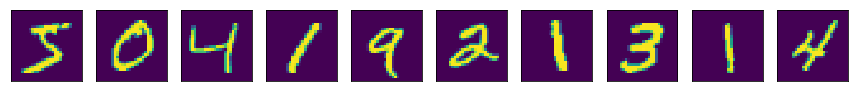

In [8]:
show_images(mnist.train,10)

In [9]:
show_labels(mnist.train,10)

array([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])

In [10]:
mnist.train.labels.shape

(60000, 10)

In [11]:
sess = tf.InteractiveSession()

In [12]:
#定义计算模型
x = tf.placeholder(tf.float32,[None, 784])
w = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))
y = tf.nn.softmax(tf.matmul(x,w) + b)
y_ = tf.placeholder(tf.float32,[None,10])

In [13]:
#定义损失函数
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))

In [14]:
#定义优化策略
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

In [15]:
#初始化参数
tf.global_variables_initializer().run()

In [16]:
#训练
for step in range(1000):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    train_step.run({x:batch_xs, y_:batch_ys})

In [17]:
#估计训练效果
correct_preception = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_preception, tf.float32))
print accuracy.eval({x:mnist.test.images, y_:mnist.test.labels})

0.9184
